In [1]:
!nvidia-smi

Sun Nov 22 23:55:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 450.66       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     On   | 00000000:19:00.0 Off |                  Off |
| 61%   80C    P2   260W / 260W |  31836MiB / 48601MiB |     97%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     On   | 00000000:1A:00.0 Off |                  Off |
| 34%   

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import torch
import torch.nn as nn
import datetime
import time
%matplotlib notebook
from IPython.core.debugger import set_trace
from torch_geometric.data import Data, Dataset, InMemoryDataset, DataLoader,DataListLoader
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU, BatchNorm1d, LayerNorm
from torch_geometric.nn import GCNConv, GENConv, DeepGCNLayer, DataParallel
import pyvista as pv
from threading import Thread
import vtk
from IPython.display import HTML, display
from pyvirtualdisplay import Display
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
np.random.seed(0)
torch.manual_seed(0)
pv.set_plot_theme("document")

In [3]:
class AdditiveThermalDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, normalize=True):
        self.seq_len = 100 # length of each sample
        self.sample_per_simulation = 100 # number of samples in each simulation
        # self.simulation_ids = ['17', '18', '19'] # for testing
        self.simulation_ids = [x.stem for x in Path('/home/mmv664/Documents/Graph_modeling/AutoGAMMA/2_simulation_results').iterdir() if x.is_dir()]
        self.normalize = normalize
        if normalize:
            self.stats = torch.load("/home/mmv664/Documents/Graph_modeling/Graph_AM_Modeling/processed/stats")
        super(AdditiveThermalDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['am_graph.simul0.data0']

    def download(self):
        pass
    
    def process(self):
        
        i = 0 # simulation_idx
        for simulation_id in self.simulation_ids:
            print("processing simulation {}!".format(simulation_id))
            j = 0 # time_idx
        
            # load simulation settings
            edge_index, elements, pos, birth_element, birth = load_simulation_input(simulation_id)
            toolpath, state, endTime = load_toolpath(simulation_id)
            
            # temperature output
            temperature = load_simulation_output(simulation_id)
            temperature = torch.clamp(temperature, 300.0, 2000.0)

            # edge feature (length of each edge)
            edge_pos = pos[edge_index.long()]
            edge_dis = ((edge_pos[:, 0, :] - edge_pos[:, 1, :])**2).sum(dim = 1)
            
            # boundary feature (distance to fixed boundary condition at z = -20)
            boundary = pos[:, 2] + 20.0

            assert (temperature.shape[1] == pos.shape[0])

            seed = np.random.permutation(temperature.shape[0]-self.seq_len)[0:self.sample_per_simulation] # the starting time of each sample 
            torch.save(seed, osp.join(self.processed_dir, 'simul{}.seed'.format(i)))
            j = 0
            for start_time in seed:
                x_data = torch.Tensor([])
                y_data = torch.Tensor([])
                birth_data = torch.Tensor([])
                for time_step in range(start_time, start_time + self.seq_len):
                    toolpath_current_step = toolpath[time_step]
                    state_current_step = state[time_step]   
                    r2 = (pos[:, 0] - toolpath_current_step[0])**2 + (pos[:, 1] - toolpath_current_step[1])**2 + (pos[:, 2] - toolpath_current_step[2])**2 + 0.1
                    if state_current_step == 1:
                        laser_feature = 1/r2
                    else:
                        laser_feature = r2 * 0.0                   

                    temp_time_step = temperature[time_step, :]
                    # temp_time_step_next = temperature[time_step + 1, :]

                    birth_time_step = (birth < time_step * 0.1).float()
                    # birth_time_step_next = (birth < (time_step + 1) * 0.1).float()

                    birth_time_element = (birth_element < time_step * 0.1).float()

                    x = torch.cat([
                    #              temp_time_step.unsqueeze(1),
                                   birth_time_step.unsqueeze(1),
                                   boundary.unsqueeze(1),
                                   laser_feature.unsqueeze(1)], dim = 1)
                    y = torch.cat([temp_time_step.unsqueeze(1),
                    #              temp_time_step_next.unsqueeze(1),
                    #              birth_time_step_next.unsqueeze(1)
                                  ], dim = 1)

                    x_data = torch.cat((x_data, x.unsqueeze(0)),0)
                    y_data = torch.cat((y_data, y.unsqueeze(0)),0)
                    birth_data = torch.cat((birth_data, birth_time_element.unsqueeze(0)),0)

                data = Data(x=x_data, y=y_data, birth_element=birth_data)
                torch.save(data, osp.join(self.processed_dir, 'am_graph.simul{}.data{}'.format(i,j)))

                j = j + 1
                if j%40 == 0:
                    print("{:.2f} %".format(j/2))

            const_data = Data(pos = pos, edge_index=edge_index.t().contiguous(), edge_attr = edge_dis, elements=elements)
            torch.save(const_data, osp.join(self.processed_dir, 'am_graph.simul{}.const'.format(i)))
            i += 1
            
    def len(self):
        return self.sample_per_simulation * len(self.simulation_ids)

    def get(self, idx):
        i = idx//self.sample_per_simulation
        j = idx%self.sample_per_simulation
        constant_data = torch.load(osp.join(self.processed_dir, 'am_graph.simul{}.const'.format(i)))
        data = torch.load(osp.join(self.processed_dir, 'am_graph.simul{}.data{}'.format(i,j)))
        data_x = data['x']
        data_x[:,:,2] = self.smooth(data['x'][:,:,2].clamp(0, 1.0), base_temp = 0.35)
        data_e = constant_data['edge_attr']
        
        data_y = self.smooth(data['y'], base_temp = 5000)
       
        if self.normalize:
            # normalize boundary feature to the range of 0-1
            data_x[:,:,1] = (data_x[:,:,1] - self.stats[1,2]) / (self.stats[1,3] - self.stats[1,2])
            # normalize laser feature to mean of zeros and std of 1
            #data_x[:,:,2] = (data_x[:,:,2] - self.stats[2,2]) / (self.stats[2,3] - self.stats[2,2])
            # nomalize edge feature to mean of zero and std of 1
            data_e = 1.0/data_e**0.5
            # normalize temperature to the range of 0-1
            data_y = (data_y - 300) / 6200 #6.5K
            #data_y = (data_y - self.stats[3,2]) / (self.stats[3,3] - self.stats[3,2])
            
        return Data(
                    x=data_x.transpose(0,1)[:,0:self.seq_len,:], 
                    y=data_y.transpose(0,1)[:,0:self.seq_len,:], 
                    pos=constant_data['pos'], 
                    edge_index=constant_data['edge_index'],
                    edge_attr=data_e.unsqueeze(1),
                    birth_element=data['birth_element'].transpose(0,1)[:,0:self.seq_len],
                    elements=constant_data['elements']
                   )
    def smooth(self, data, base_temp = 5000):
        added = (data - base_temp).clamp(min = 0) / 10
        final = data.clamp(max = base_temp) + added
        return final

In [4]:
dataset = AdditiveThermalDataset('/home/mmv664/Documents/Graph_modeling/Graph_AM_Modeling', normalize=True)

In [5]:
num_element = []
num_node = []
num_edge = []
for i in range (0,45):
    data = dataset[i*100]
    num_element.append(data.elements.size()[0])
    num_node.append(data.pos.size()[0])
    num_edge.append(data.edge_attr.size()[0])

In [6]:
print(max(num_element))
print(min(num_element))
print(max(num_node))
print(min(num_node))

35705
9998
42133
12645


In [7]:
#dataset = dataset.shuffle()
dataset = dataset[4000:4500]

In [8]:
dataset[0]['x'][:,:,2].max()

tensor(0.4150)

In [9]:
dim = 8
input_features = 3
output_features = 1
num_layers = 6
#dropout = 0.

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.node_encoder = Linear(input_features, dim)
        self.edge_encoder = Linear(1, dim)
        self.layers = torch.nn.ModuleList()
        for i in range(1, num_layers + 1):
            conv = GENConv(dim, dim, aggr='softmax',
                           t=1.0, learn_t=True, num_layers=2, norm='layer')
            norm = LayerNorm(dim, elementwise_affine=True)
            act = ReLU(inplace=True)
            layer = DeepGCNLayer(conv, norm, act, block='res+', dropout=0.1,
                                 ckpt_grad=i % 3)
            self.layers.append(layer)
        self.lin = Linear(dim, output_features)
        self.gru1 = torch.nn.GRU(dim, dim, num_layers=3)
        self.gru2 = torch.nn.GRU(dim, 1)
        


    def forward(self, data):
        X, Y, edge_index, edge_attr = data.x, data.y, data.edge_index, data.edge_attr
        edge_attr = self.edge_encoder(edge_attr)
        # extract features from time sequence 
        for i in range(1,X.shape[1]):
            x = X[:,i,:]
            x = self.node_encoder(x)
            
            feature = self.layers[0].conv(x, edge_index, edge_attr)
            
            for layer in self.layers[1:]:
                feature = layer(feature, edge_index, edge_attr)
                
            feature = self.layers[0].act(self.layers[0].norm(feature))
            feature = F.dropout(feature, p=0.1, training=self.training)
            
            if i == 1:
                features = feature.unsqueeze(0)
            else:
                features = torch.cat((features, feature.unsqueeze(0)),0)
        
        # initial state: node birth info
        h_0 = X[:,0,0].reshape(1,-1,1).repeat([3,1,dim]).contiguous()
        out,h = self.gru1(features,h_0)
        
        # initial state: temp
        h_0 = Y[:,0,:].unsqueeze(0).contiguous()
        out,h = self.gru2(out,h_0)
        
        return out

In [10]:
path = 'Models/RGNN_final.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model = DataParallel(model)
model = model.to(device)
model.load_state_dict(torch.load(path))
model.eval()

DataParallel(
  (module): Net(
    (node_encoder): Linear(in_features=3, out_features=8, bias=True)
    (edge_encoder): Linear(in_features=1, out_features=8, bias=True)
    (layers): ModuleList(
      (0): DeepGCNLayer(block=res+)
      (1): DeepGCNLayer(block=res+)
      (2): DeepGCNLayer(block=res+)
      (3): DeepGCNLayer(block=res+)
      (4): DeepGCNLayer(block=res+)
      (5): DeepGCNLayer(block=res+)
    )
    (lin): Linear(in_features=8, out_features=1, bias=True)
    (gru1): GRU(8, 8, num_layers=3)
    (gru2): GRU(8, 1)
  )
)

In [11]:
def display_temp_error(temp,data,time=99,zoom=3.0,show_edges=False,
                        camera_position = [(200, 100, 100),(10.0, 10.0, 0.0), (0.0, 0.0, 1.0)],
                        camera_position_zoom = [(200/3, 100/3, 100/3),(10.0, 10.0, 0.0), (0.0, 0.0, 1.0)]):
    display = Display(visible=0)
    _ = display.start()
    output_show = temp[time-1,:,0]
    range_ = [-max(-output_show.min(),output_show.max()), max(-output_show.min(),output_show.max())]
    active_elements = [element.tolist() for element, birth_time in zip(data['elements'], data['birth_element'][:,time]) if birth_time > 0.5]
    active_cells = np.array([item for sublist in active_elements for item in [8] + sublist])
    active_cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(active_elements))
    points = np.array(data['pos'])
    active_grid = pv.UnstructuredGrid(active_cells, active_cell_type, points)
    active_grid.point_arrays['temp'] = np.array(output_show)
    elements = [element.tolist() for element, birth_time in zip(data['elements'], data['birth_element']) if True]
    cells = np.array([item for sublist in elements for item in [8] + sublist])
    cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(elements))
    grid = pv.UnstructuredGrid(cells, cell_type, points)
    grid.point_arrays['temp'] = np.array(output_show)
    clipped = grid.clip('x', origin=(-2,0,0), invert=True)
    p = pv.Plotter(shape=(1, 1), window_size=([800, 300]),)
    p.camera_position = camera_position_zoom
    p.add_mesh(active_grid, show_edges=show_edges, scalars='temp',cmap="coolwarm",clim = range_)
    p.show()

In [12]:
def display_temp_history(temp,data,time=99,zoom=3.0,show_edges=False,
                        camera_position = [(200, 100, 100),(10.0, 10.0, 0.0), (0.0, 0.0, 1.0)],
                        camera_position_zoom = [(200/3, 100/3, 100/3),(10.0, 10.0, 0.0), (0.0, 0.0, 1.0)]):
    display = Display(visible=0)
    _ = display.start()
    output_show = temp[time-1,:,0]
    range_ = [0, 1]
    active_elements = [element.tolist() for element, birth_time in zip(data['elements'], data['birth_element'][:,time]) if birth_time > 0.5]
    active_cells = np.array([item for sublist in active_elements for item in [8] + sublist])
    active_cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(active_elements))
    points = np.array(data['pos'])
    active_grid = pv.UnstructuredGrid(active_cells, active_cell_type, points)
    active_grid.point_arrays['temp'] = np.array(output_show)
    elements = [element.tolist() for element, birth_time in zip(data['elements'], data['birth_element']) if True]
    cells = np.array([item for sublist in elements for item in [8] + sublist])
    cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(elements))
    grid = pv.UnstructuredGrid(cells, cell_type, points)
    grid.point_arrays['temp'] = np.array(output_show)
    clipped = grid.clip('x', origin=(-2,0,0), invert=True)
    p = pv.Plotter(shape=(1, 1), window_size=([800, 300]),)
    p.camera_position = camera_position_zoom
    p.add_mesh(active_grid, show_edges=show_edges, scalars='temp',cmap="coolwarm",clim = range_)
    p.show()


In [50]:
# test_id = np.random.randint(0,len(dataset))
test_id = 1
data = [dataset[test_id]]
with torch.no_grad():
    prediction =  model(data).to("cpu")
data = data[0].to("cpu")
output = data.y[:,1:,:].transpose(0,1)
#output = output*(5000-300) + 300
#prediction = prediction*(5000-300) + 300
birth = data.x[:,1:,0].transpose(0,1).unsqueeze(2)
prediction = prediction*birth
output = output*birth
error = np.array(prediction - output)
error.shape

(99, 19666, 1)

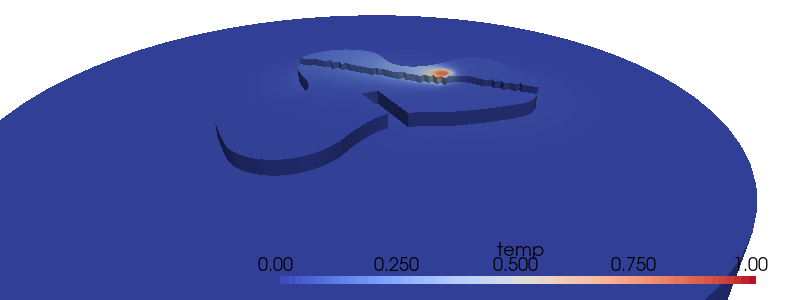

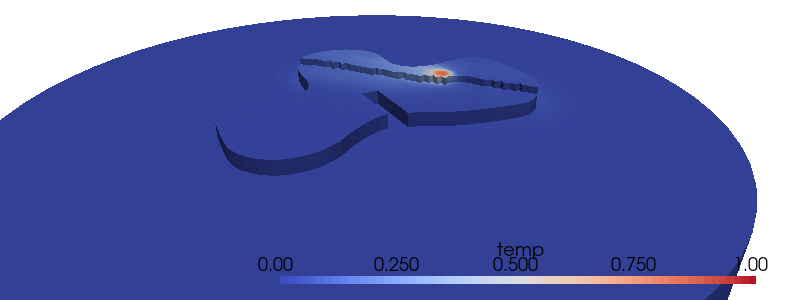

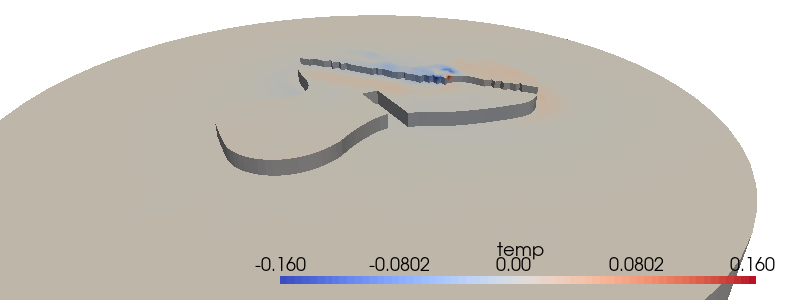

In [51]:
t = 95
display_temp_history(output,data,time=t)
display_temp_history(prediction,data,time=t)
display_temp_error(prediction-output,data,time=t)

In [52]:
prediction.max()

tensor(0.8297)

In [53]:
output[55,:,0].argmax()

tensor(10128)

<IPython.core.display.Javascript object>


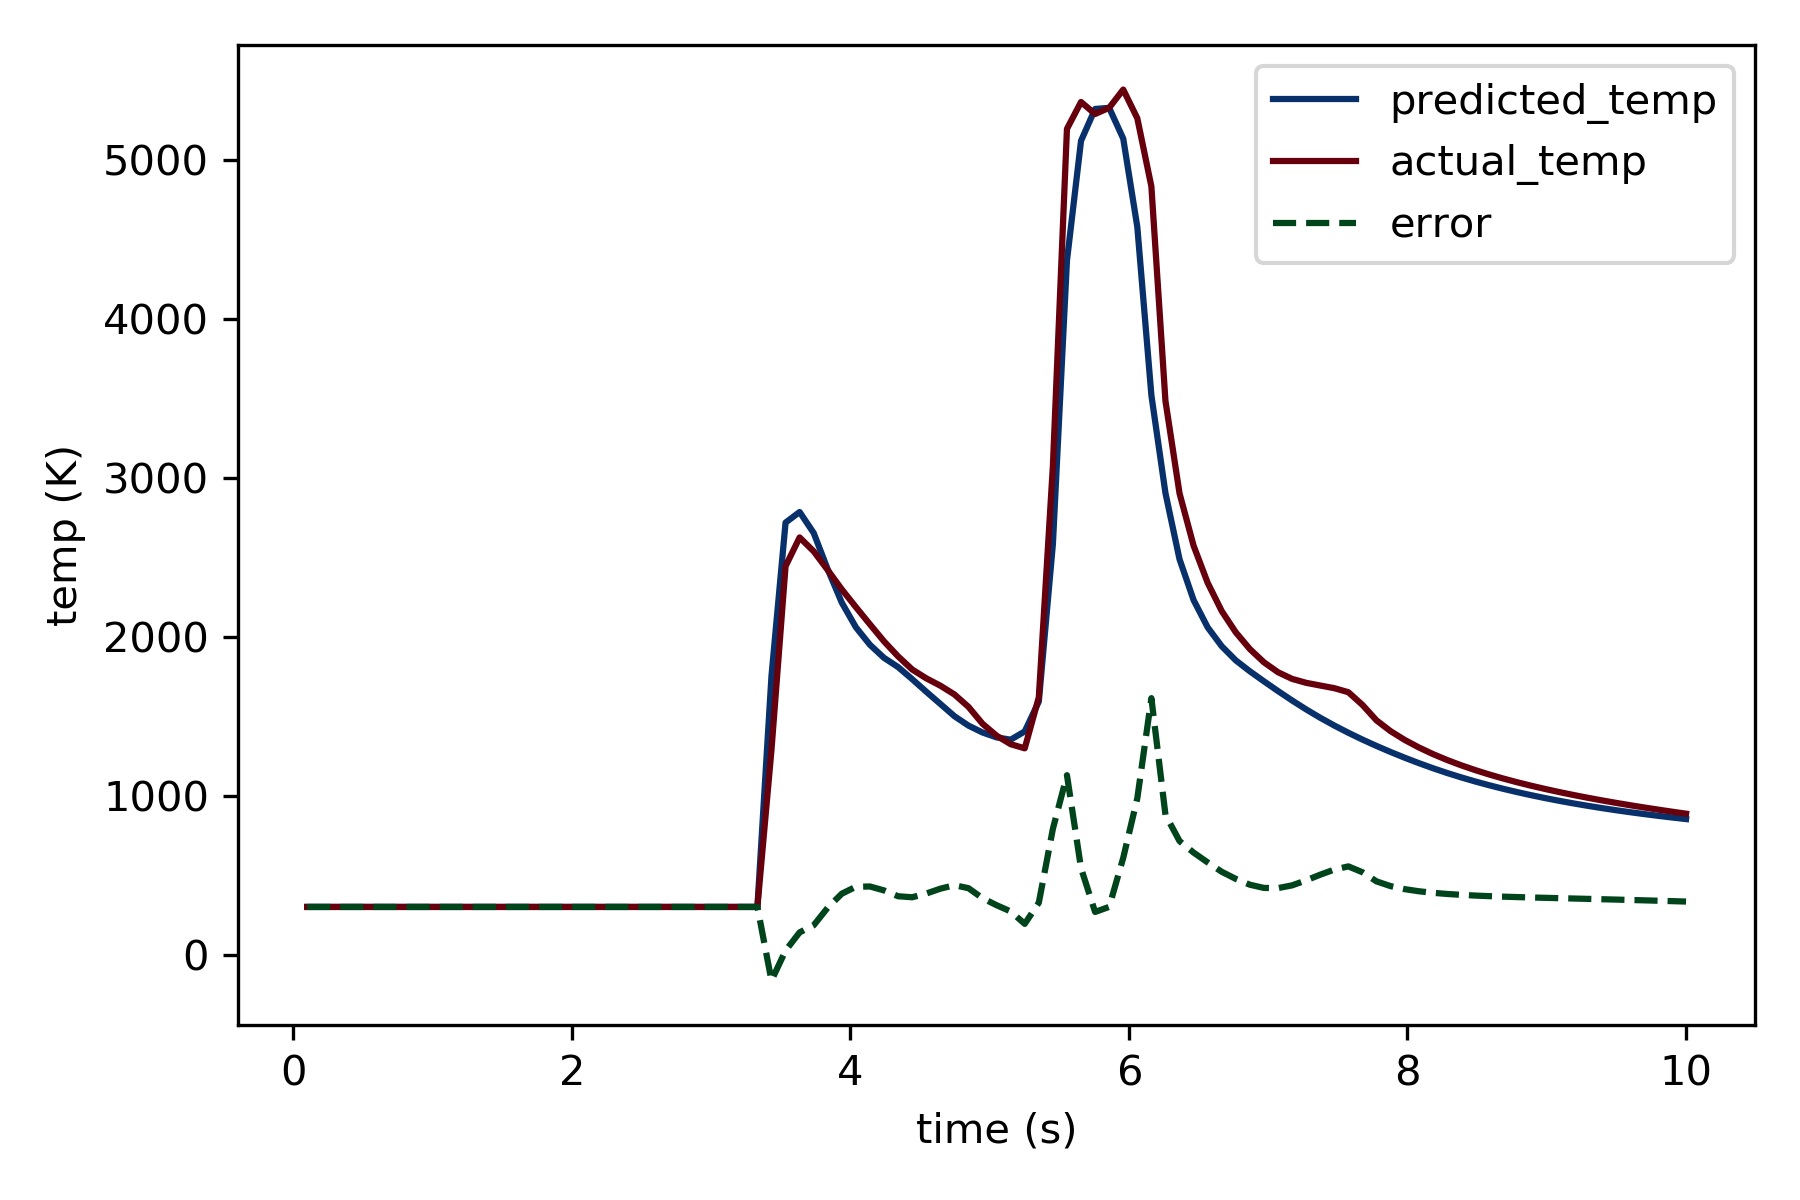

In [54]:
point_id = 10128
prediction-output[:,point_id,0]
cmap1 = cm.get_cmap('Blues')(np.linspace(1, 0.5, 3))
cmap2 = cm.get_cmap('Reds')(np.linspace(1, 0.5, 3))
cmap3 = cm.get_cmap('Greens')(np.linspace(1, 0.5, 3))

fig, ax = plt.subplots(1, figsize = (6,4))
ax.plot(np.linspace(0.1, 10, 99),prediction[:,point_id,0]*6200+300, color=cmap1[0], label='predicted_temp')
ax.plot(np.linspace(0.1, 10, 99),output[:,point_id,0]*6200+300, color=cmap2[0], label='actual_temp')
ax.plot(np.linspace(0.1, 10, 99),(output[:,point_id,0]-prediction[:,point_id,0])*6200+300, 
        color=cmap3[0], label='error', linestyle='dashed')
ax.set_ylabel('temp (K)')
ax.set_xlabel('time (s)')
ax.legend()
#ax.set_ylim(-0.3,1.3)
# ax.set_ylim([-1,5])
plt.tight_layout()
plt.show()

In [ ]:
errs = torch.zeros(99,1)
for data in dataset:
    with torch.no_grad():
        prediction =  model([data]).to("cpu")
    data = data.to("cpu")
    output = data.y[:,1:,:].transpose(0,1)
    birth = data.x[:,1:,0].transpose(0,1).unsqueeze(2)
    prediction = prediction*birth
    output = output*birth
    error = output.shape[1] * torch.mean(torch.square(prediction-output),dim=1) / torch.sum(birth,dim = 1)
    errs = errs + error/len(dataset) 

<IPython.core.display.Javascript object>


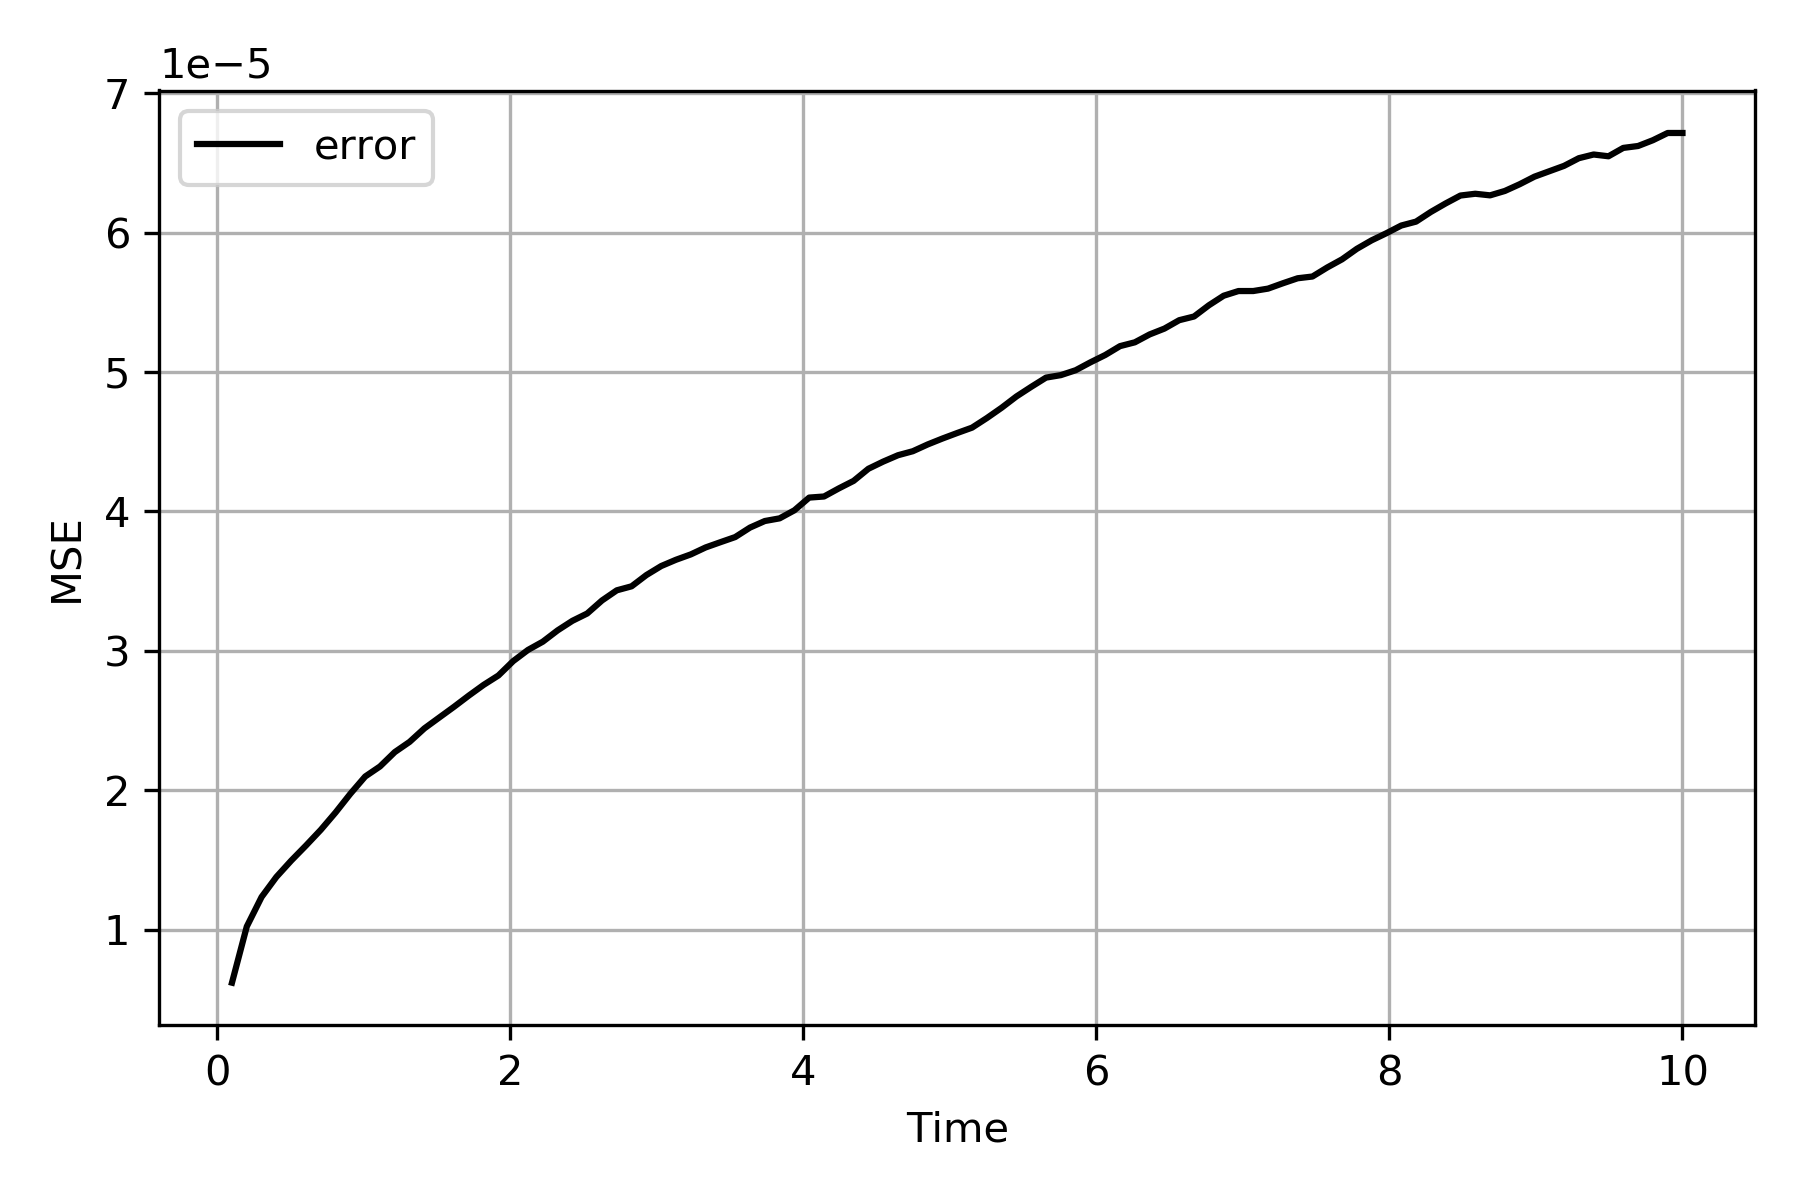

In [48]:
fig, ax = plt.subplots(1, figsize = (6,4))
time = (np.linspace(0.1, 10, 99))
ax.plot(time, errs, label='error', c='k')
ax.set_xlabel('Time', color='k')
ax.set_ylabel('MSE', color='k')
ax.legend()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.grid()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


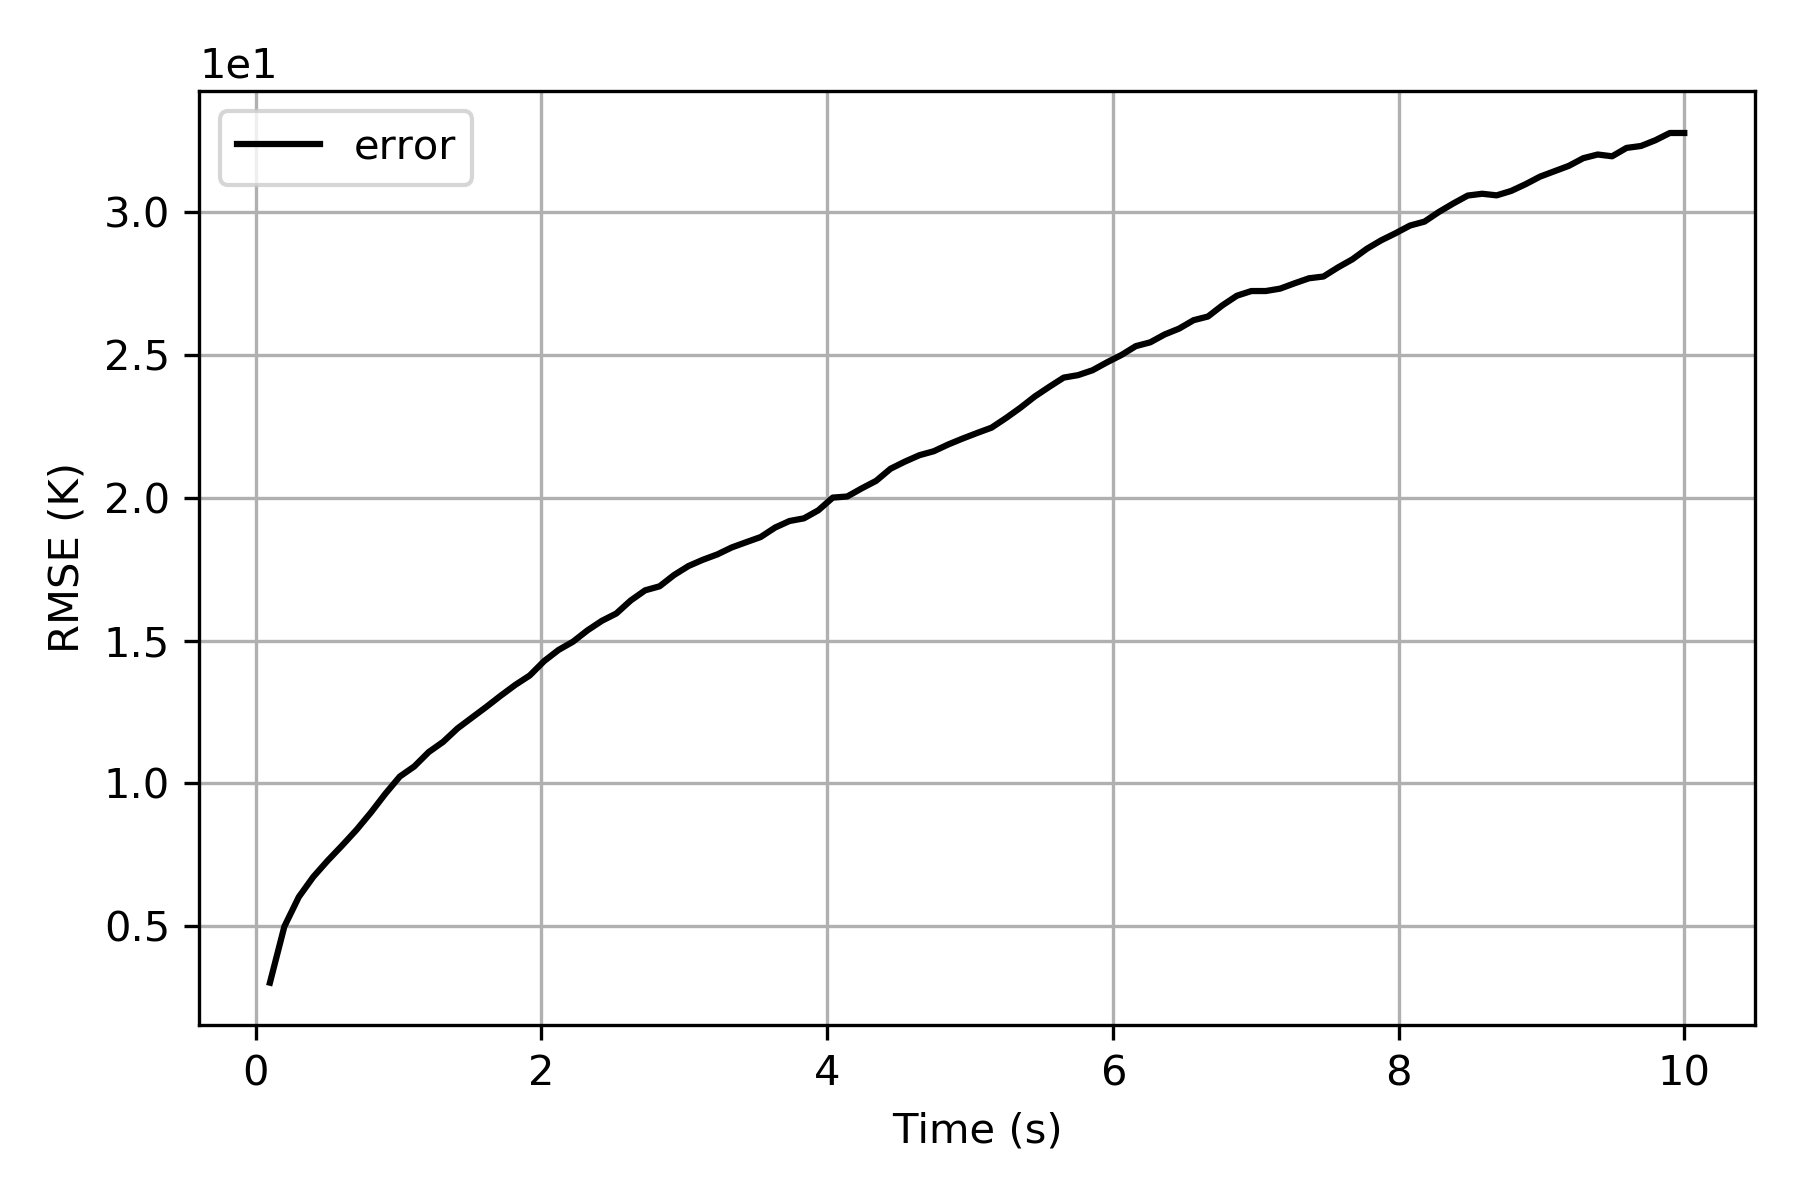

In [49]:
fig, ax = plt.subplots(1, figsize = (6,4))
time = (np.linspace(0.1, 10, 99))
ax.plot(time, (errs*6200*6200**0.5), label='error', c='k')
ax.set_xlabel('Time (s)', color='k')
ax.set_ylabel('RMSE (K)', color='k')
ax.legend()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.grid()
plt.tight_layout()
plt.show()

In [ ]:
torch.cuda.empty_cache() 